## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys

import pandas as pd
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [2]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [3]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]

In [ ]:
nam_audios

# Analyse DATA

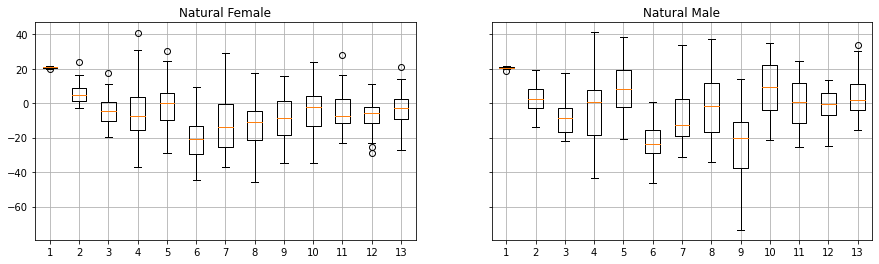

In [4]:
naf_mfcc_median = np.array([np.median(mfcc(naf[1], naf[0], nfft=1024), axis=0) for naf in naf_audios])# ...
nam_mfcc_median = np.array([np.median(mfcc(nam[1], nam[0], nfft=1024), axis=0) for nam in nam_audios])# ...


f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

On a trouvé que les paires de MFCC (8,9), (8,4), (9,4) pourraient être utiles pour la prédiction. Mais pour cette expérience, on peut simplement utiliser l'ensemble complet des MFCC.

# MLP

## Exploring the number of epochs and hyper parameters

In [5]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

mfccs = np.concatenate((
    nam_mfcc_median,
    naf_mfcc_median
))

# We use -1 and 1 for classes because we use the tanh function
classes = np.concatenate(
    (
        np.repeat(-1, len(nam_mfcc_median)),
        np.repeat(1, len(naf_mfcc_median))
    )
)
# Using pandas for format
df_mfcc = pd.DataFrame(data=mfccs)

df_mfcc['class'] = classes.tolist()
# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [ ]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()

        MSE[i_h, i, :] = nn.fit((df_mfcc.loc[:, df_mfcc.columns != 'class'], df_mfcc['class']),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

In [ ]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

On peut voir que l'erreur ne diminue pas de manière significative après ~100 Epochs.
Un learning rate de 0.001 et un momentum de 0.5 donne des résultats qui semblent acceptables

## Exploring the number of hidden neurons
Knowing that there are no significant improvements after 50 iterations, we can now further explore how the complexity of the model (number of hidden neurons) is linked to the generalization performance (test error). The following snippet allows you to explore both the number of epochs and the number of hidden neurons without restarting the training.


In [6]:
EPOCHS = 150
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [ ]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            df_mfcc.to_numpy(),    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

In [ ]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Avec ces représentations nous pouvons voir qu'un nombre de neurones dans la couche cachée supérieur à 15 réduit les performances de notre modèle sur le set de test. A priori, cela signifie qu'il perd en capacité de généralisation.

## Final model

Notre modèle final aura donc 15 neurones, 0.001 de learning rate, un momentum de 0.5 et 80 epochs

In [7]:
nn = mlp.MLP([13,15,1], 'tanh')

In [12]:
def k_fold_cross_validation_without_matrix(mlp, dataset, k=5, learning_rate=0.01, momentum=0.7, epochs=100, threshold=None):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = cv.split_dataset(dataset, k)
    target_test = []
    output_test = []

    for k_i in np.arange(k):
        mlp.init_weights()

        training_parts = set(np.arange(k))
        training_parts.remove(k_i)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k_i]

        input_data = dataset_train[:,0:mlp.n_inputs]
        output_data = dataset_train[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]
        input_data_test = dataset_test[:,0:mlp.n_inputs]
        output_data_test = dataset_test[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]

        mlp.fit((input_data, output_data),
                learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        MSE_train, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += MSE_train

        MSE_test, temp_out = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += MSE_test
        output_test.append(temp_out)
        target_test.append(output_data_test)

    target_test = np.concatenate(target_test, axis=0)
    output_test = np.concatenate(output_test, axis=0)

    if threshold is None:
        return (MSE_train_mean / k, MSE_test_mean / k)
    else:
        return (MSE_train_mean / k, MSE_test_mean / k, target_test, output_test)

In [45]:
N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc.to_numpy(),
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=80,
                                                              threshold=0.0)
    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

..........

In [49]:
conf_mat = cv.compute_confusion_matrix(targets, outputs, 0.0)

y_pred = [-1 if y[0] < 0.0 else 1 for y in outputs.tolist()]
y_true = [-1 if y[0] < 0.0 else 1 for y in targets.tolist()]

[float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,


In [50]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  [0.00969101 0.01158236 0.01335902 0.01218801 0.01084943 0.01461603
 0.01245587 0.01239983 0.01371381 0.01701425]
MSE test:  [0.26195272 0.1971239  0.26632603 0.16265709 0.17243826 0.22001966
 0.24405556 0.27585747 0.27208121 0.37380548]
Confusion matrix:
[[341.  19.]
 [ 38. 322.]]


Calcul des performances...

In [56]:
import sklearn.metrics as metrics

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred))
print("Recall", metrics.recall_score(y_true, y_pred))

Accuracy:  0.9208333333333333
F1-Score:  0.9228687415426252
Recall 0.9472222222222222
